In [1]:
import glob
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import squidpy as sq
import gc
import sklearn.cluster as cluster
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score

import torch
import torch.nn as nn
import sys
sys.path.append("../")
from Dataloader.Dataset import *
from torch.utils.data import DataLoader


Dataset path: /afm01/UQ/Q2051


In [2]:
label_mapping = {
        'Invasive cancer + stroma + lymphocytes': 'Cancer',
        'Invasive cancer + stroma': 'Cancer',
        'Stroma': 'Immune',
        'Invasive cancer + lymphocytes': 'Cancer',
        'Necrosis': 'Other',
        'Invasive cancer': 'Cancer',
        'Lymphocytes': 'Immune',
        'DCIS': 'Cancer',
        'Normal glands + lymphocytes': 'Immune',
        'Normal + stroma + lymphocytes': 'Immune',
        'Artefact': 'Other',
        'Stroma + adipose tissue': 'Immune',
        'Adipose tissue': 'Immune',
        'Uncertain': 'Other',
        'TLS': 'Immune',
        'Cancer trapped in lymphocyte aggregation': 'Immune',
        'Invasive cancer + adipose tissue + lymphocytes': 'Cancer',
        'Normal duct': 'Normal'
    }

# Clustering function

In [3]:
colornorm = "reinhard"
name_slides = ["1142243F", "1160920F", "CID4290", "CID4465", "CID44971", "CID4535"]
# gene_list = pd.read_excel('../../Predictable_genes/Marker_list/Intersection_marker_genes.xlsx')["gene_name"].to_list()

In [4]:
import gc
import pandas as pd
import scanpy as sc
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score as ari_score, normalized_mutual_info_score as nmi_score

def Space_region_detection(tmp, color="Grouped annotations", title="Ground truth"):
    """
    Perform space region detection using PCA and KMeans clustering.

    Parameters:
    - tmp: AnnData object
    - color: Column name for color annotations (default: "Grouped annotations")
    - title: Title for the plot (default: "Ground truth")

    Returns:
    - tmp: Updated AnnData object
    - ari: Adjusted Rand Index
    - nmi: Normalized Mutual Information
    """
    # Dimensionality reduction
    sc.pp.pca(tmp)

    # Label encoding
    unique_lbl = set(tmp.obs[color])
    dict1 = {list(unique_lbl)[key]: key for key in range(len(unique_lbl))}
    tmp.obs["lbl"] = tmp.obs[color].map(dict1)
    l = tmp.obs["lbl"].to_numpy()

    # Clustering
    kmeans = KMeans(n_clusters=len(tmp.obs["lbl"].unique()), init="k-means++", random_state=0).fit(tmp.obsm['X_pca'])
    p = kmeans.labels_.astype(str)
    tmp.obs['cluster'] = p

    # Clustering performance assessment
    ari = round(ari_score(p, l), 3)
    nmi = round(nmi_score(p, l), 3)
    # print(f"ari_score: {ari}")
    # print(f"nmi_score: {nmi}")

    gc.collect()
    return tmp, ari, nmi

def organize_res(aris, nmis):
    """
    Organize clustering results into a DataFrame.

    Parameters:
    - aris: List of Adjusted Rand Indices
    - nmis: List of Normalized Mutual Informations

    Returns:
    - df1: DataFrame containing ARI and NMI for each slide
    """
    df1 = pd.DataFrame(aris, index=[0]).T
    df2 = pd.DataFrame(nmis, index=[0]).T
    df1.columns = ["ARI"]
    df2.columns = ["NMI"]
    df1['NMI'] = df2.NMI
    df1["Slides"] = df1.index
    return df1


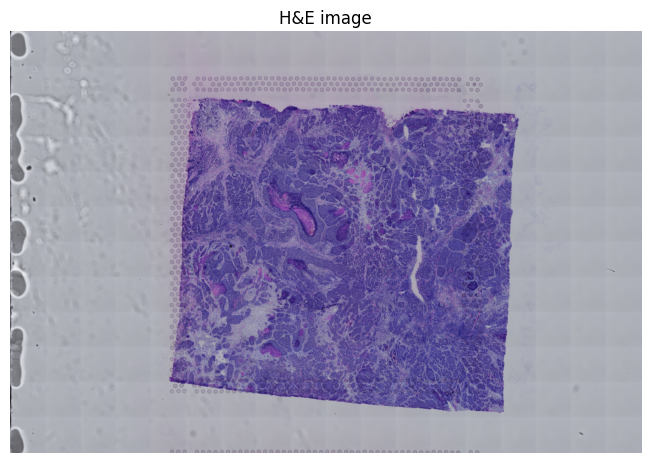

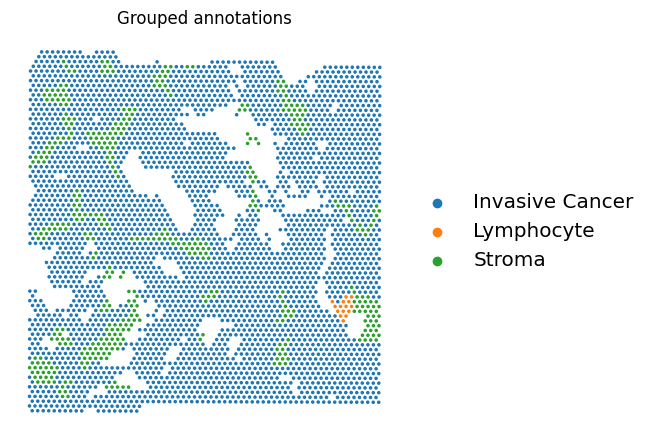

In [6]:
gt = sc.read_h5ad(f"../Results/BC_visium/gt_stimage_BC_visium_reinhard_1142243F_func.h5ad")
tmp = sc.read_h5ad(f"../Dataset/BC_visium/1142243F.h5ad")
gt.uns = tmp.uns
sq.pl.spatial_scatter(gt, color=None, frameon=False, title=f"H&E image",
                    legend_fontsize="x-large",  )
sq.pl.spatial_scatter(gt, color="Grouped annotations", frameon=False, title=f"Grouped annotations", img=False,
                    legend_fontsize="x-large", )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

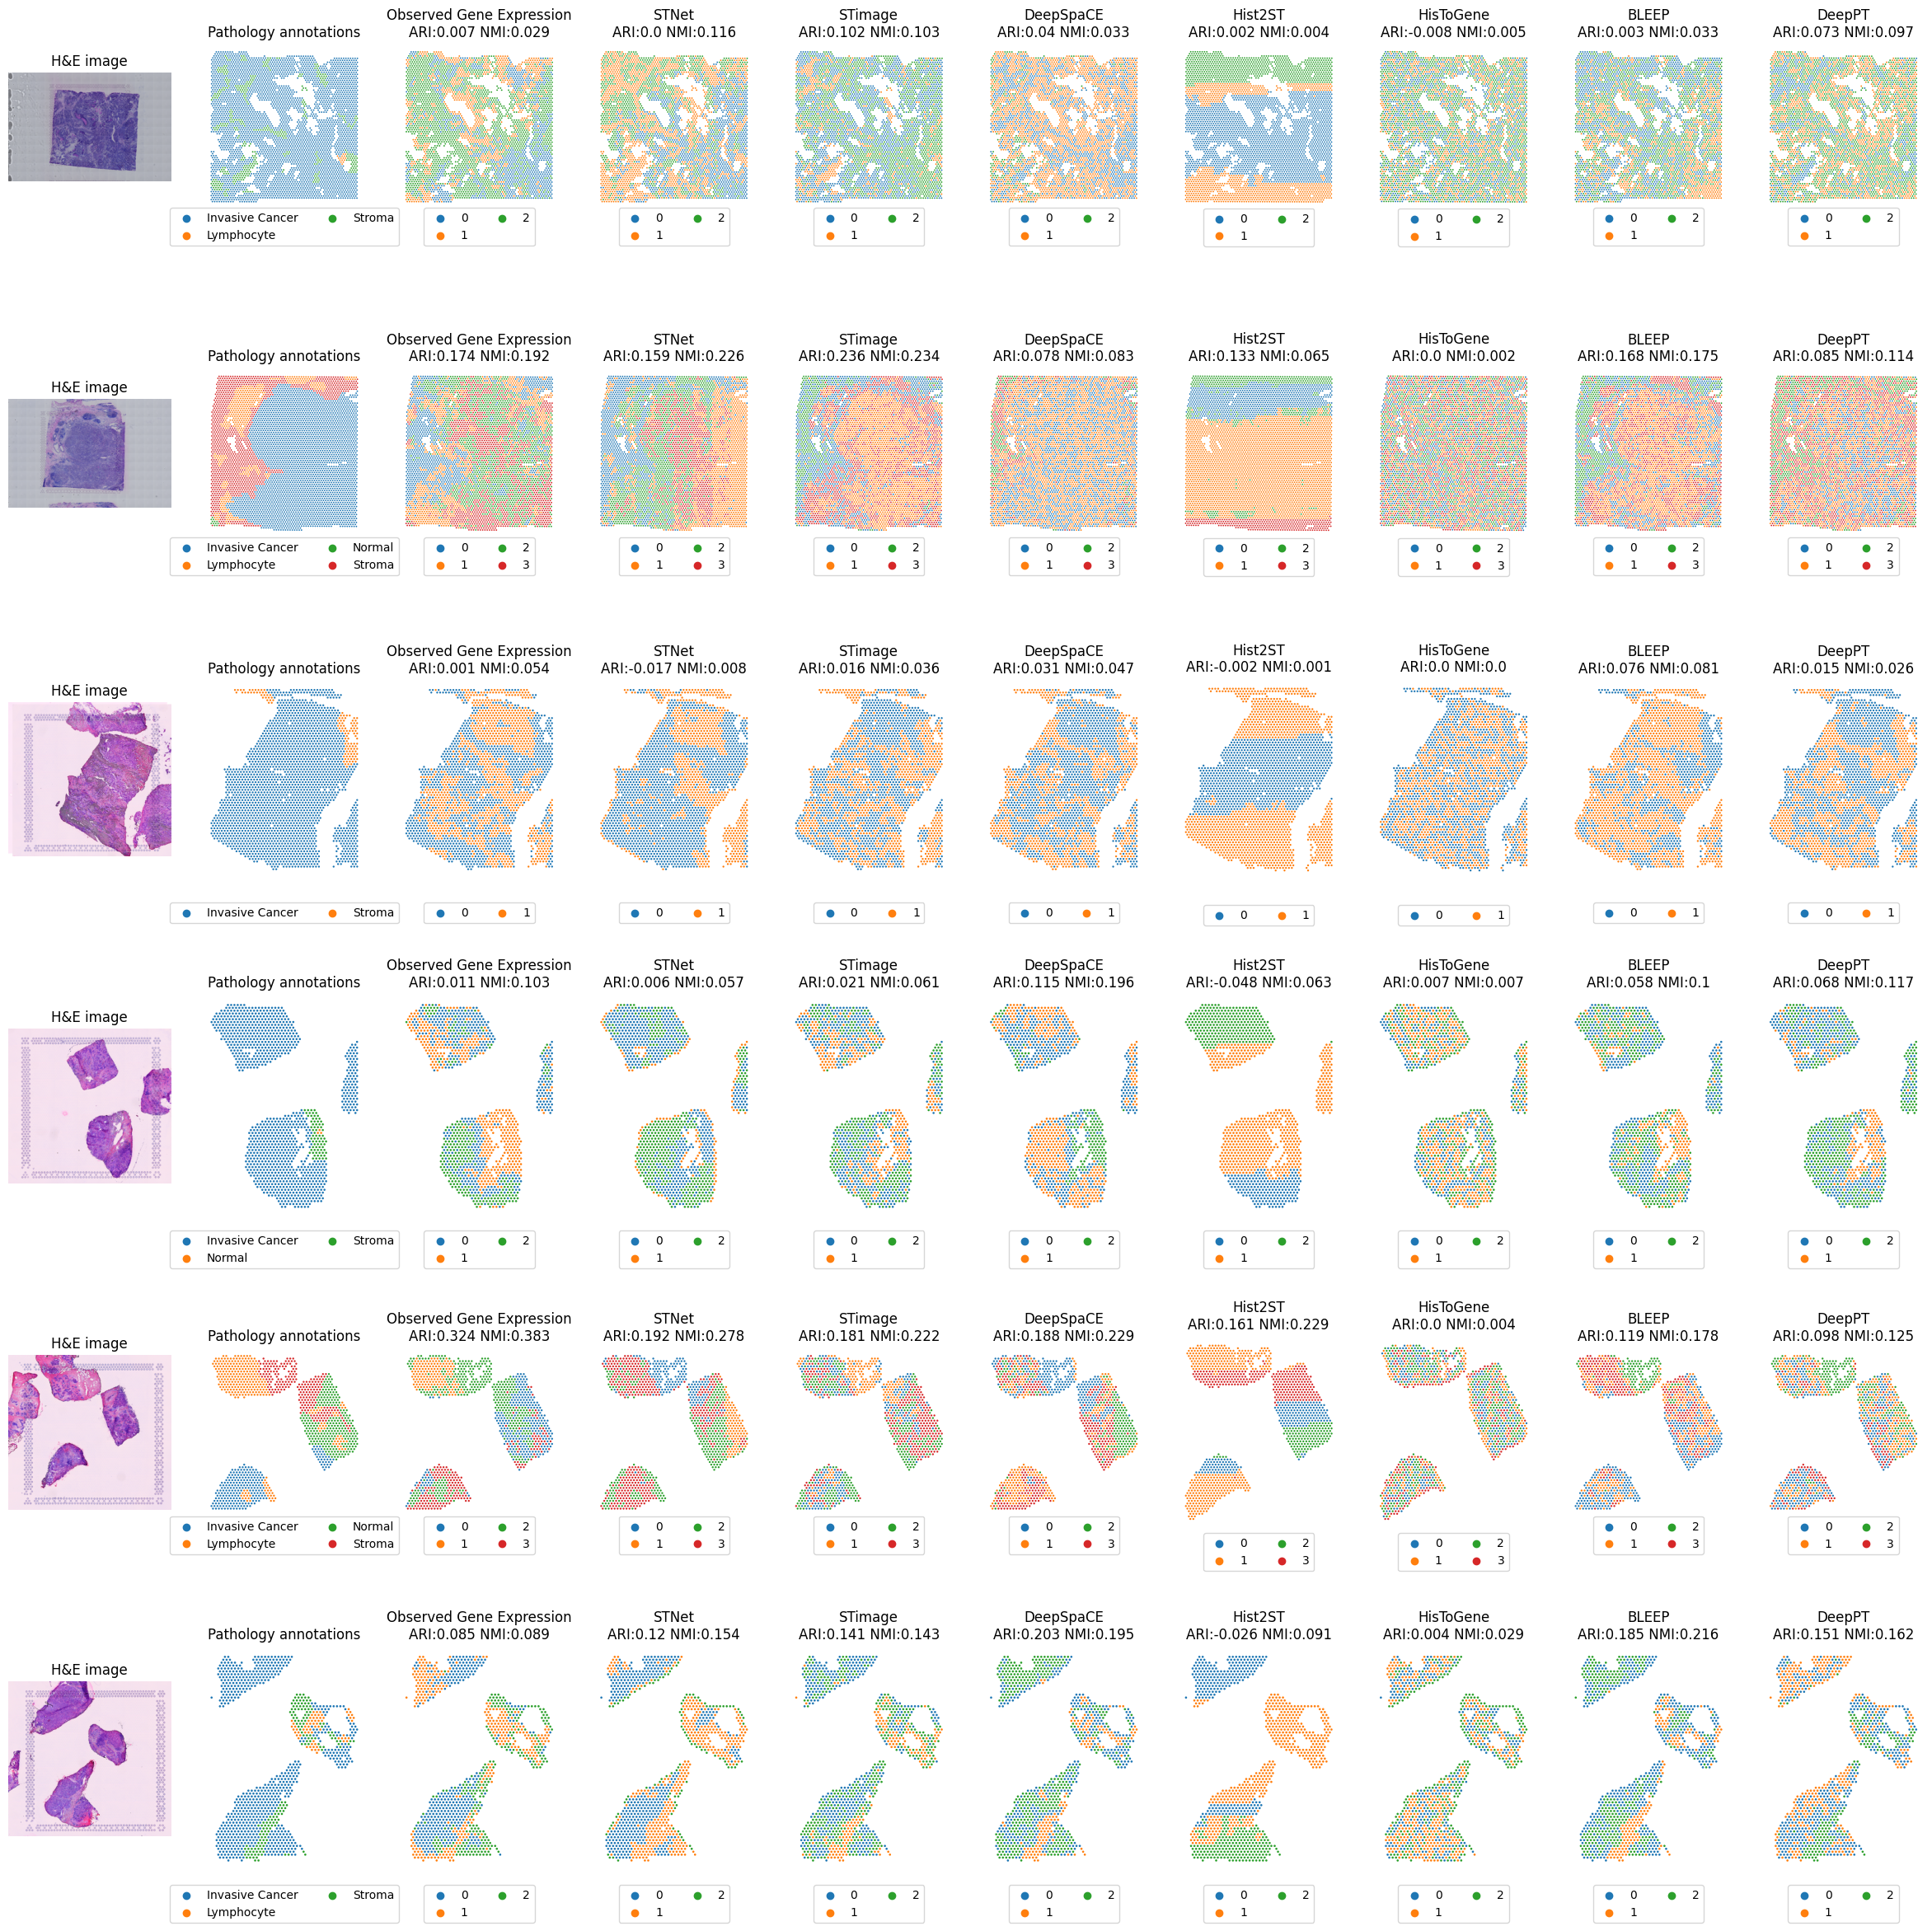

In [11]:
import gc
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd

# Assuming Space_region_detection is a function defined elsewhere in your code

# Lists to collect ARI, NMI, method names, and name_slides
aris = []
nmis = []
methods = []
name_slides_list = []

fig, axs = plt.subplots(len(name_slides), len(name_slides)+4, figsize=(30, 30))

# Loop over folds
for fold in range(len(name_slides)):
    name = name_slides[fold]
    
    # Ground Truth (Pathology annotation)
    gt = sc.read_h5ad(f"../Results/BC_visium/gt_stimage_BC_visium_reinhard_{name}_func.h5ad")
    tmp = sc.read_h5ad(f"../Dataset/BC_visium/{name}.h5ad")
    gt.uns = tmp.uns    
    sq.pl.spatial_scatter(gt, color=None, frameon=False, title=f"H&E image",
                          legend_fontsize="x-large", ax=axs[fold][0])
    sq.pl.spatial_scatter(gt, color="Grouped annotations", frameon=False, title=f"Pathology annotations", img=False,
                          legend_fontsize="x-large", ax=axs[fold][1])

    # Observation
    # print("Observation Gene Expression.")
    gt, pred_ari, pred_nmi = Space_region_detection(gt, title="Predicted Gene Expression")
    aris.append(pred_ari)
    nmis.append(pred_nmi)
    methods.append("Observation")
    name_slides_list.append(name)
    sq.pl.spatial_scatter(gt, color="cluster", frameon=False, title=f"Observed Gene Expression\nARI:{pred_ari} NMI:{pred_nmi}", img=False,
                          legend_fontsize="x-large", ax=axs[fold][2])

    # Prediction
    for i, model_name in enumerate(["stnet", "stimage", "deepspace", "hist2st", "histogene", "bleep", "deeppt"]):
        pred = sc.read_h5ad(f"../Results/BC_visium/pred_{model_name}_BC_visium_reinhard_{name}_func.h5ad")
        gt = sc.read_h5ad(f"../Results/BC_visium/gt_{model_name}_BC_visium_reinhard_{name}_func.h5ad")
        tmp = sc.read_h5ad(f"../Dataset/BC_visium/{name}.h5ad")
        gt.X = pred.X
        gt.uns = tmp.uns  
        
        # Rename models for better visualization
        model_name_display = {
            "stimage": "STimage",
            "stnet": "STNet",
            "hist2st": "Hist2ST",
            "histogene": "HisToGene",
            "deepspace": "DeepSpaCE",
            "deeppt": "DeepPT",
            "bleep": "BLEEP"
        }.get(model_name, model_name)
        
        gt, pred_ari, pred_nmi = Space_region_detection(gt, title="Predicted Gene Expression")
        aris.append(pred_ari)
        nmis.append(pred_nmi)
        methods.append(model_name_display)
        name_slides_list.append(name)
        
        sq.pl.spatial_scatter(gt, color="cluster", title=f"{model_name_display}\nARI:{pred_ari} NMI:{pred_nmi}", img=False,
                            frameon=False, legend_fontsize="x-large", ax=axs[fold][i + 3])
    
    for i in range(1, 10):
        for j in range(6):
            # Move legend to the bottom of the plot
            axs[j][i].legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2)
        
    plt.savefig(f"BC_visium_clustering.pdf")
    gc.collect()

# # Create a DataFrame at the end
# result_df = pd.DataFrame({'Name_Slides': name_slides_list, 'Method': methods, 'ARI': aris, 'NMI': nmis})
# result_df.to_csv("cluster_results.csv", index=False)


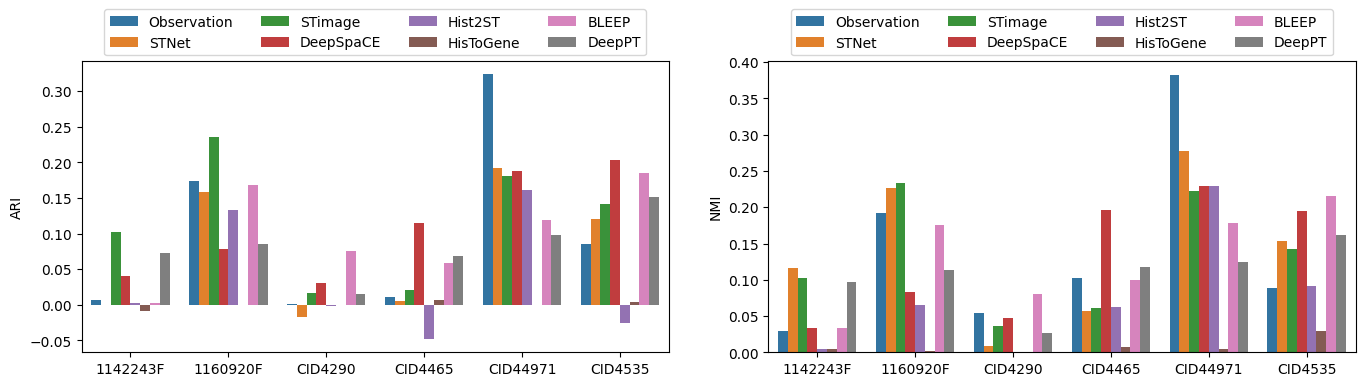

In [53]:
import seaborn as sns
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

sns.barplot(data = result_df, x = "Name_Slides", y = "ARI", hue = "Method", ax=axs[0])
sns.barplot(data = result_df, x = "Name_Slides", y = "NMI", hue = "Method", ax=axs[1])

for i in range(len(axs)):
    # Move legend to the bottom of the plot
    axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4)
    axs[i].set(xlabel=None)
plt.tight_layout()
plt.savefig("BC_visium_clustering_barplot.pdf")


In [38]:
result_df

Name_Slides       Method    ARI    NMI
0     1142243F  Observation  0.007  0.029
1     1142243F        STNet  0.000  0.116
2     1142243F      STimage  0.102  0.103
3     1142243F    DeepSpaCE  0.040  0.033
4     1142243F      Hist2ST  0.002  0.004
5     1142243F    HisToGene -0.008  0.005
6     1142243F        BLEEP  0.003  0.033
7     1142243F       DeepPT  0.073  0.097
8     1160920F  Observation  0.174  0.192
9     1160920F        STNet  0.159  0.226
10    1160920F      STimage  0.236  0.234
11    1160920F    DeepSpaCE  0.078  0.083
12    1160920F      Hist2ST  0.133  0.065
13    1160920F    HisToGene  0.000  0.002
14    1160920F        BLEEP  0.168  0.175
15    1160920F       DeepPT  0.085  0.114
16     CID4290  Observation  0.001  0.054
17     CID4290        STNet -0.017  0.008
18     CID4290      STimage  0.016  0.036
19     CID4290    DeepSpaCE  0.031  0.047
20     CID4290      Hist2ST -0.002  0.001
21     CID4290    HisToGene  0.000  0.000
22     CID4290        BLEEP  0.076  0.081
23     CID4290       DeepPT  0.015  0.026
24     CID4465  Observation  0.011  0.103
25     CID4465        STNet  0.006  0.057
26     CID4465      STimage  0.021  0.061
27     CID4465    DeepSpaCE  0.115  0.196
28     CID4465      Hist2ST -0.048  0.063
29     CID4465    HisToGene  0.007  0.007
30     CID4465        BLEEP  0.058  0.100
31     CID4465       DeepPT  0.068  0.117
32    CID44971  Observation  0.324  0.383
33    CID44971        STNet  0.192  0.278
34    CID44971      STimage  0.181  0.222
35    CID44971    DeepSpaCE  0.188  0.229
36    CID44971      Hist2ST  0.161  0.229
37    CID44971    HisToGene  0.000  0.004
38    CID44971        BLEEP  0.119  0.178
39    CID44971       DeepPT  0.098  0.125
40     CID4535  Observation  0.085  0.089
41     CID4535        STNet  0.120  0.154
42     CID4535      STimage  0.141  0.143
43     CID4535    DeepSpaCE  0.203  0.195
44     CID4535      Hist2ST -0.026  0.091
45     CID4535    HisToGene  0.004  0.029
46     CID4535        BLEEP  0.185  0.216
47     CID4535       DeepPT  0.151  0.162